# Single-Color Dataset

One novel capability of META-SiM is that it can handle both single- and double- color intensity signals with the same model. In this tutorial, we will demo the classification of single-color data with META-SiM. 

We will use the data from paper:

Johnson-Buck, A. et al. Kinetic fingerprinting to identify and count single nucleic acids. Nat. Biotechnol. 33,
730–732 (2015). 

In this dataset, we want to identify traces with a clear binding-unbinding kinetic pattern.

In [1]:
import openfret
import metasim
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
train_data = metasim.fret.data.OneColorDataset(
    openfret.read_data('saved_dataset/openfret/simreps_train.json'),
    channel_type='532nm-laser',
)
test_data = metasim.fret.data.OneColorDataset(
    openfret.read_data('saved_dataset/openfret/simreps_test.json'),
    channel_type='532nm-laser',
)

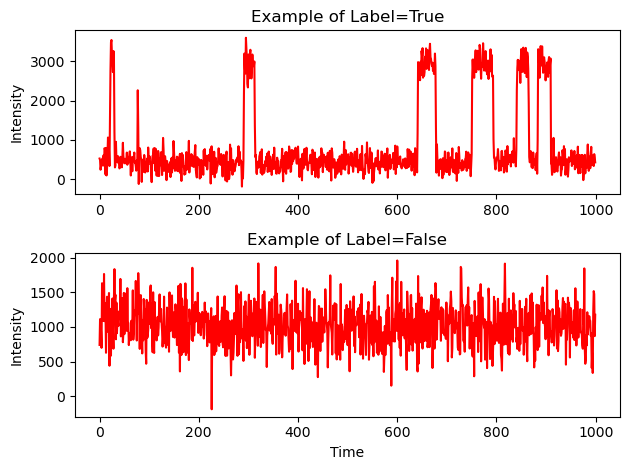

In [3]:
fig, axes = plt.subplots(2)
for trace in train_data.traces[100:]:
    if trace.metadata['manual_label'] == True:
        for channel in trace.channels:
            color = 'r'
            axes[0].plot(channel.data, color=color)
            axes[0].set_ylabel('Intensity')
            axes[0].set_title('Example of Label=True')
        break
for trace in train_data.traces:
    if trace.metadata['manual_label'] == False:
        for channel in trace.channels:
            color = 'r'
            axes[1].plot(channel.data, color=color)
            axes[1].set_ylabel('Intensity')
            axes[1].set_xlabel('Time')
            axes[1].set_title('Example of Label=False')
        break
plt.tight_layout()

# Classification Model

Here we use META-SiM's built-in function to train a logistic regression model for this problem, based on the embeddings generated by META-SiM. 

For this dataset, we want the model to have very low false-positive rate. Therefore, we will set a very high weight on the negative label.

In [4]:
model = metasim.fret.Model()
with tf.device('/CPU:0'):
    # If your GPU is faster than CPU, change the device to /GPU:0.
    embedding = model(train_data)

  0%|          | 0/3904 [00:00<?, ?it/s]

In [5]:
label = np.array([trace.metadata['manual_label'] for trace in train_data.traces])

In [6]:
task_model = metasim.fret.tuning.train_classification(
    embedding,
    label,
    class_weight={True: 1, False: 2E2}
)

In [7]:
pred = task_model.predict(embedding)
prob = task_model.predict_proba(embedding)

# Evaluation on test data

We can use test data collected from different experimental trials to test the performance of the classification model. 

Specifically, we would like to check whether the positives are true positives with clear kinetic patterns, e.g. binding-unbinding transitions.

In [8]:
with tf.device('/CPU:0'):
    # If your GPU is faster than CPU, change the device to /GPU:0.
    embedding_test = model(test_data)
label_test = np.array([trace.metadata['manual_label'] for trace in test_data.traces])

  0%|          | 0/5720 [00:00<?, ?it/s]

In [9]:
prob_test = task_model.predict_proba(embedding_test)
pred_test = task_model.predict(embedding_test)

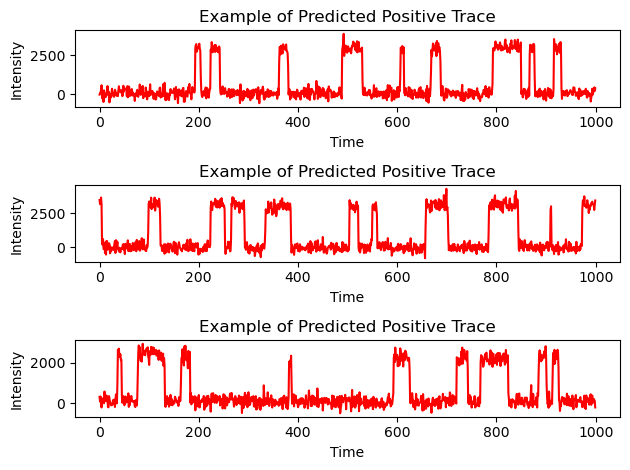

In [10]:
fig, axes = plt.subplots(3)
count = 0
for trace, p in zip(train_data.traces, pred_test):
    if not p:
        continue
    for channel in trace.channels:
        color = 'r'
        axes[count].plot(channel.data, color=color)
        axes[count].set_ylabel('Intensity')
        axes[count].set_xlabel('Time')
        axes[count].set_title('Example of Predicted Positive Trace')
    count += 1
    if count == len(axes):
        break
plt.tight_layout()

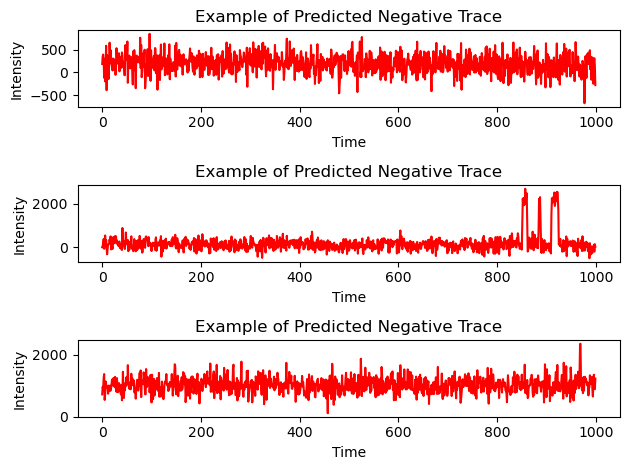

In [11]:
fig, axes = plt.subplots(3)
count = 0
for trace, p in zip(train_data.traces, pred_test):
    if p:
        continue
    for channel in trace.channels:
        color = 'r'
        axes[count].plot(channel.data, color=color)
        axes[count].set_ylabel('Intensity')
        axes[count].set_xlabel('Time')
        axes[count].set_title('Example of Predicted Negative Trace')
    count += 1
    if count == len(axes):
        break
plt.tight_layout()

# Save and load model

Now that we have a trained and validated the model, we will save it to re-use it in the future. Models can be easily saved and read with buit-in functions.

In [12]:
task_model.save_to_json('/tmp/saved_model.json')

In [13]:
loaded_model = metasim.fret.tools.tuning.ModelConfig.load_from_json(
    '/tmp/saved_model.json',
)